# Neural similarity

In [1]:
# import sys
import os

import torch
import torch.nn as nn
import torchvision.models as models
import pandas as pd
import numpy as np
from scipy import stats

import cv2
import matplotlib.pyplot as plt
import seaborn as sns

import torchvision
from torchvision import models, transforms, datasets

from annoy import AnnoyIndex
import random

In [2]:
FOOD101_CLASSES = 101

def fix_names(state_dict):
    state_dict = {key.replace('module.', ''): value for (key, value) in state_dict.items()}
    return state_dict

model = models.mobilenet_v2(num_classes=FOOD101_CLASSES)  
checkpoint_path = 'mobilenet_v2_food101/pytorch_model.bin'

if os.path.isfile(checkpoint_path):
    print("=> loading checkpoint '{}'".format(checkpoint_path))
    

    checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
    weights = fix_names(checkpoint['state_dict'])
    model.load_state_dict(weights)

    print("=> loaded checkpoint '{}' (epoch {})"
            .format(checkpoint_path, checkpoint['epoch']))

=> loading checkpoint 'mobilenet_v2_food101/pytorch_model.bin'
=> loaded checkpoint 'mobilenet_v2_food101/pytorch_model.bin' (epoch 27)


In [3]:
test_dataset = datasets.Food101(
        root='data/train',
        split = 'test'
    )
train_dataset = datasets.Food101(
        root='data/train',
        split = 'train',
    )

In [4]:
model.eval()

# Get the output of the last hidden layer
last_hidden_layer_output = None
def hook(module, input, output):
    global last_hidden_layer_output
    x = nn.functional.adaptive_avg_pool2d(output, (1, 1))
    last_hidden_layer_output = torch.flatten(x, 1)


In [6]:
data = pd.read_csv('final.csv')

In [7]:
data.shape

(75750, 1283)

In [8]:
def get_image_features(img):
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])
    transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            normalize,
        ])
    img = transform(img)
    hook_handle = model.features.register_forward_hook(hook)
    with torch.no_grad():
        res = model(img.unsqueeze(0))
    # Detach the hook
    hook_handle.remove()
    return last_hidden_layer_output[0]

In [9]:
f = 1280  # Length of item vector that will be indexed

In [10]:
t = AnnoyIndex(f, 'angular')
for _,x in data.iterrows():
    vals = x.values[1:1281]
    t.add_item(int(x['index']), vals)

t.build(100) # 10 trees
t.save('test.ann')



True

In [11]:
u = AnnoyIndex(f, 'angular')
u.load('test.ann') # super fast, will just mmap the file

True

In [12]:
def get_image_nearest(img,ann,n=5):
    features = get_image_features(img)
    values = data.values[:,1:1281].shape
    res = ann.get_nns_by_vector(features,n=n,include_distances=True)

    return res

In [13]:
len(data[data['correct'] == data['prediction']]) / len(data)

0.7404752475247525

In [21]:
idx = 10000  #interesting examples: 1488, 107 (missclass), 1 - ideal
index,distances = get_image_nearest(test_dataset[idx][0],u)

In [22]:
data[data.index.isin(index)]['correct']

5019    73
5862     4
5976     4
5995     4
9528    78
Name: correct, dtype: int64

Class: edamame, 33


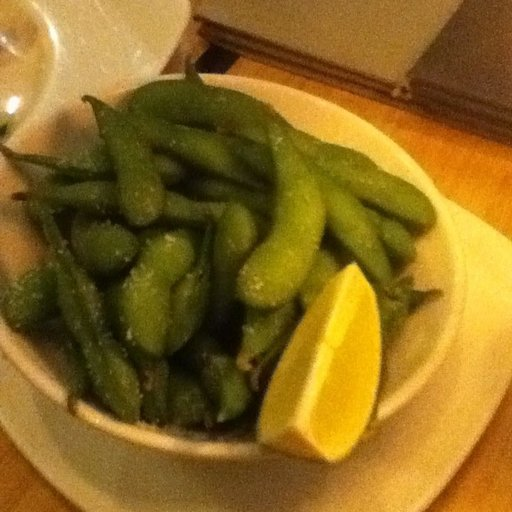

In [23]:
print(f"Class: {train_dataset.classes[test_dataset[idx][1]]}, {test_dataset[idx][1]}")
test_dataset[idx][0]


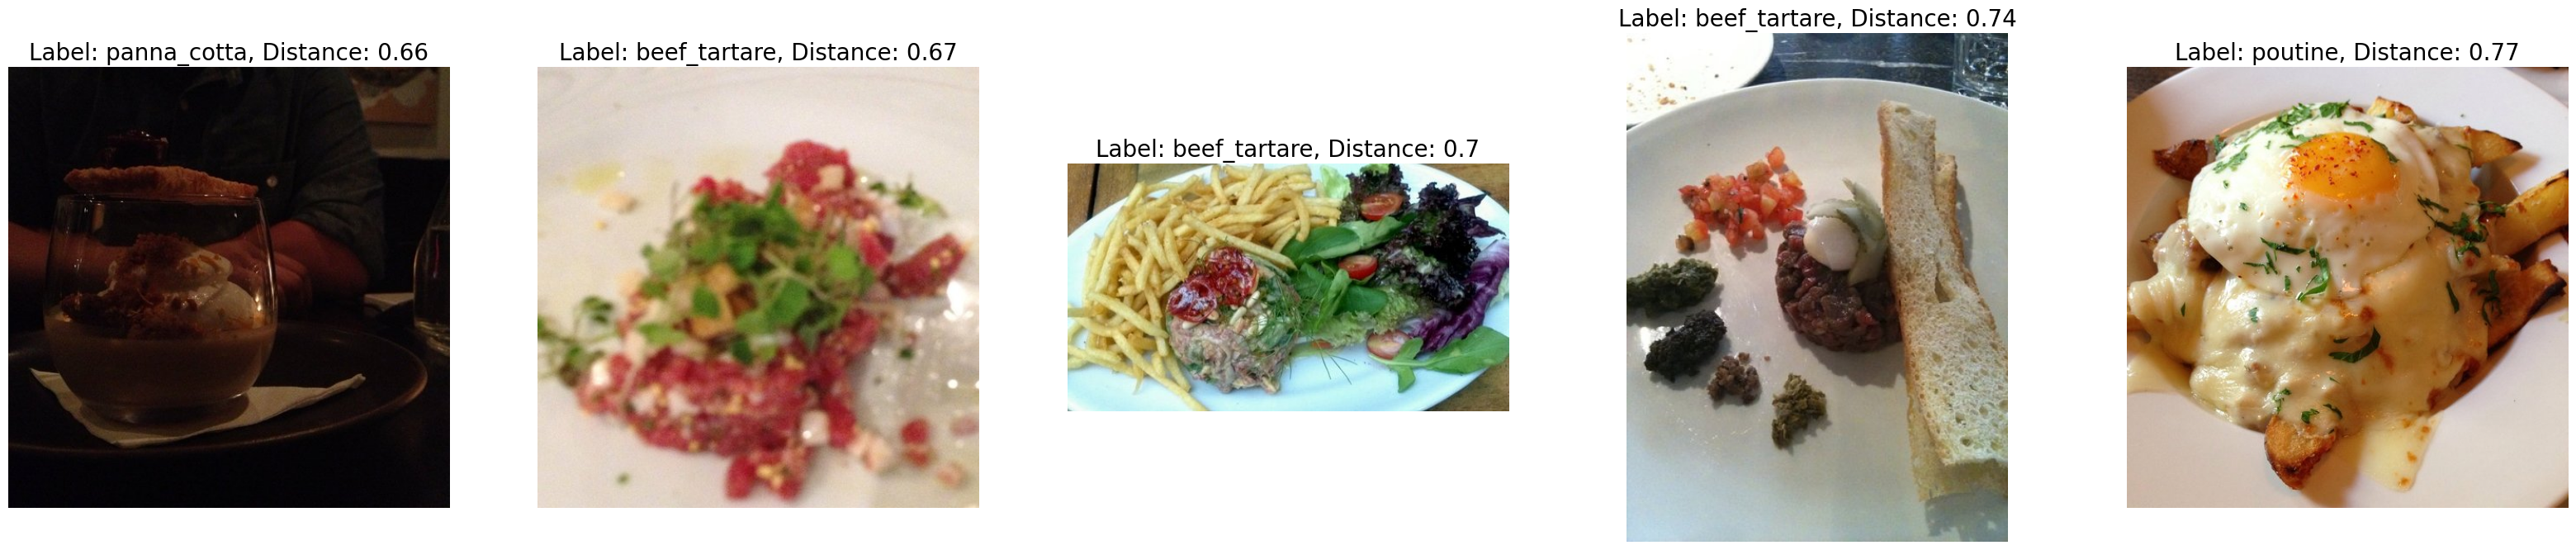

In [24]:
plt.figure(figsize=(40, 8))

for i, idx_train in enumerate(data[data.index.isin(index)].index):
    image, label = train_dataset[idx_train]  # Assuming 'dataset' is your torchvision.datasets object
    
    # Convert the tensor image to a PIL image and display it
    plt.subplot(1, 5, i + 1)  
    plt.imshow(image)  
    plt.title(f'Label: {train_dataset.classes[label]}, Distance: {round(distances[i], 2)}', fontsize=20)  
    plt.axis('off') 

plt.show()

# SIFT func

In [79]:
def calculate_sift_similarity(img1, img2, similarity_ratio = 0.8):
  
    img1, _ = img1
    img2, _ = img2

    img1 = np.array(img1)
    img2 = np.array(img2)
    gray1 = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)

    sift = cv2.SIFT_create()

    kp1, des1 = sift.detectAndCompute(gray1, None)
    kp2, des2 = sift.detectAndCompute(gray2, None)

    if des1 is None or des2 is None:   #бувало, що не знаходить дескріптори для картинки
        return 0.0 

    bf = cv2.BFMatcher(normType=cv2.NORM_L2)
    matches = bf.knnMatch(des1, des2, k=2)

    good = []
    for m, n in matches:
        if m.distance < similarity_ratio * n.distance: 
            good.append([m])

    similarity_score = len(good) / np.min([len(des1), len(des2)])   #впливає дуже сильно те, як порахувати знаменник

    return similarity_score

# SIFT demo

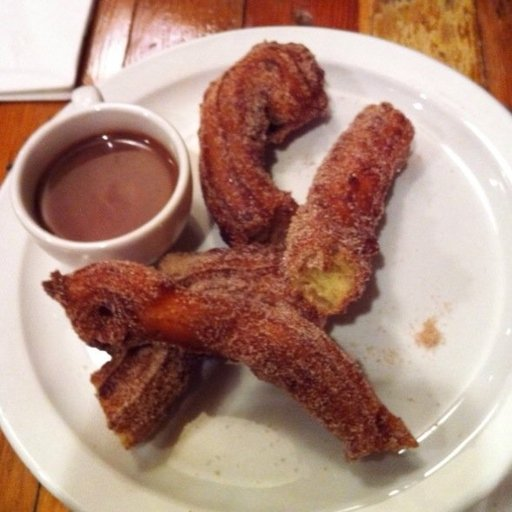

In [19]:
train_dataset[0][0]

In [20]:
calculate_sift_similarity(train_dataset[0], train_dataset[0])

1.0

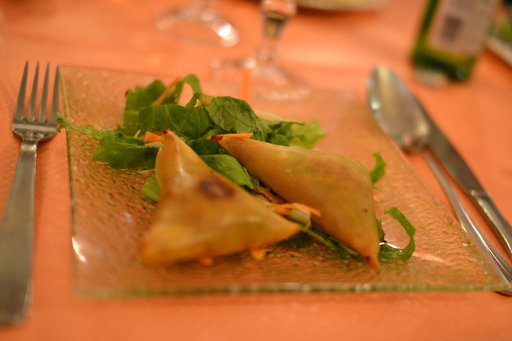

In [21]:
train_dataset[2034][0]

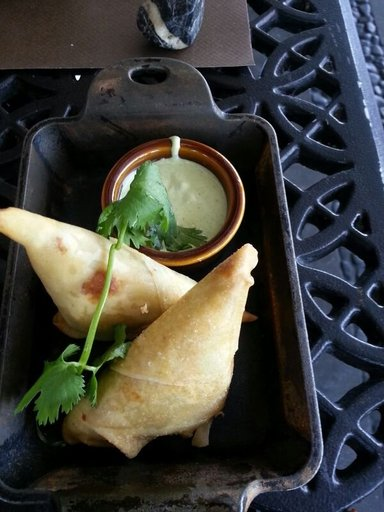

In [22]:
train_dataset[2021][0]

In [23]:
calculate_sift_similarity(train_dataset[2021], train_dataset[2034])

0.14148681055155876

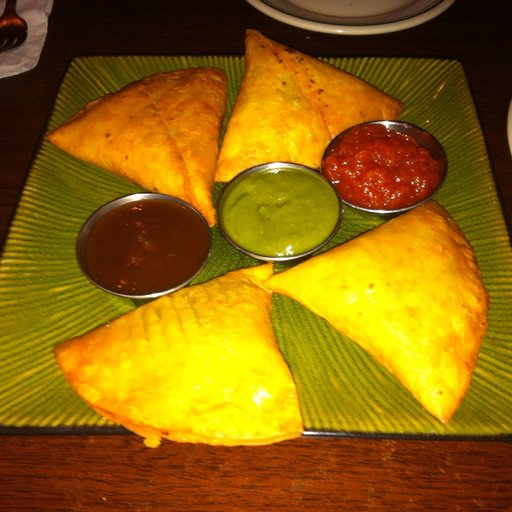

In [24]:
train_dataset[2039][0]

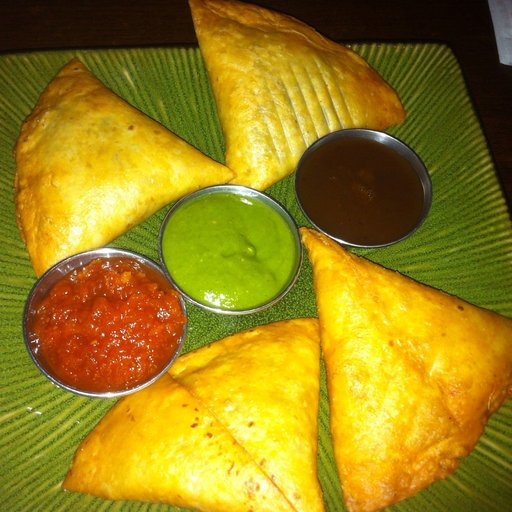

In [25]:
train_dataset[2035][0]

In [26]:
calculate_sift_similarity(train_dataset[2035], train_dataset[2039])

0.08447098976109214

In [27]:
calculate_sift_similarity(train_dataset[0], train_dataset[2039])

0.025597269624573378

# SIFT

In [93]:
input_img_idx = 5555  #9003


Class: baby_back_ribs, 1


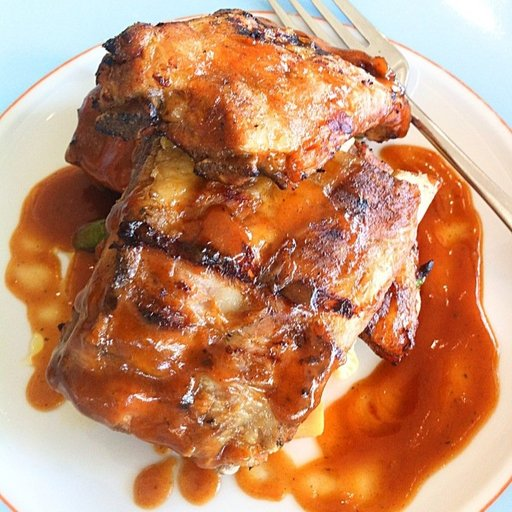

In [94]:
print(f"Class: {train_dataset.classes[test_dataset[input_img_idx][1]]}, {test_dataset[input_img_idx][1]}")
test_dataset[input_img_idx][0]


In [97]:
#get 1000 closest pictures
indeces, distances = get_image_nearest(test_dataset[input_img_idx][0], u, n=100)

In [98]:
similarities = []

for index in indeces:
    similarities.append(calculate_sift_similarity(test_dataset[input_img_idx], train_dataset[index])) 

In [99]:
results = pd.DataFrame({'sift': similarities, 
                        'cnn': distances, 
                        'picture_num': indeces, 
                        'classes': data[data.index.isin(indeces)]['correct'], 
                        'input_class': test_dataset[input_img_idx][1]})

In [100]:
results

sift       cnn  picture_num  classes  input_class
2     0.072533  0.588901         9892       23            1
7     0.229851  0.622297         7411       23            1
25    0.078624  0.634324          133       23            1
58    0.048295  0.643475         9875       23            1
68    0.065369  0.646073         9803       23            1
...        ...       ...          ...      ...          ...
9947  0.063978  0.776898         2382       81            1
9970  0.037665  0.777239          121       81            1
9979  0.082803  0.777351          268       81            1
9986  0.049020  0.778995          251       81            1
9988  0.076142  0.779149           71       81            1

[100 rows x 5 columns]

c:\Users\Yurii Shynkarov\Desktop\ucu_env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Yurii Shynkarov\Desktop\ucu_env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='sift', ylabel='cnn'>

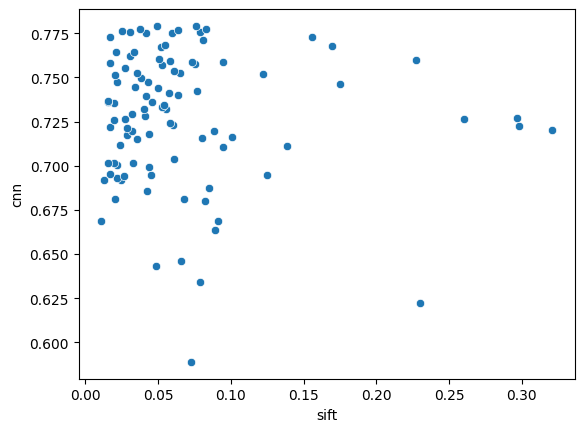

In [101]:
sns.scatterplot(data=results[results['sift'] <= 1], x='sift', y='cnn')

In [102]:
correlation, p_value = stats.spearmanr(results['sift'], results['cnn'])

In [103]:
correlation

0.015781672857322876